In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('data/listings.csv')

In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
df['amenities'][0]

'{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}'

In [5]:
amenities = df['amenities'].str.replace(r'[{}""]', '', regex=True)
amenities = amenities.str.get_dummies(',')
amenities.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,...,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet
0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,1
1,0,0,0,1,0,1,0,0,0,1,...,1,0,1,0,0,1,1,0,0,1
2,0,1,0,0,1,1,1,1,0,1,...,0,1,1,0,0,1,1,0,0,1
3,0,0,0,0,0,1,0,0,0,1,...,1,1,1,0,0,0,1,0,0,1
4,0,0,0,0,1,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,1


### Clean price

In [6]:
df['price'] = df['price'].str.replace('[$,]', '', regex=True).astype(float)

## Clean up amenities

In [7]:
amenities_cleaned = amenities.copy()

In [8]:
combining = {
    'Internet*': ['Internet', 'Wireless Internet'],
    'Smoke Detector*': ['Smoke Detector', 'Carbon Monoxide Detector'],
    'TV*': ['TV', 'Cable TV'],
    'Pets':['Pets Allowed', 'Dog(s)', 'Cat(s)', 'Other pet(s)'],
    'Washer/Dryer*': ['Dryer', 'Washer', 'Washer / Dryer']
}

In [9]:
for combined_column, columns in combining.items():
    amenities_cleaned[combined_column] = 0
    for column in columns:
        amenities_cleaned[combined_column] = amenities_cleaned[combined_column] | amenities_cleaned[column]
    amenities_cleaned.drop(columns=columns, inplace=True)
amenities_cleaned.columns = [c.replace('*', '') for c in amenities_cleaned.columns]
amenities_cleaned.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Doorman,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,...,Safety Card,Shampoo,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Internet,Smoke Detector,TV,Pets,Washer/Dryer
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
1,0,0,0,1,0,0,1,1,1,1,...,1,0,0,0,0,1,1,1,0,1
2,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,1,1,1,1,1
3,0,0,0,0,0,0,1,1,1,0,...,1,1,0,0,0,1,1,0,0,1
4,0,0,0,0,0,0,1,1,1,1,...,0,1,0,0,0,1,1,1,0,0


In [10]:
amenities_cleaned.shape

(3818, 33)

# Question 1: What are the popular faciliites? 

In [11]:
amenities_order = amenities_cleaned.sum().sort_values(ascending=False)
amenities_order

Internet                      3692
Heating                       3627
Kitchen                       3423
Smoke Detector                3291
Essentials                    3237
Washer/Dryer                  3022
TV                            2741
Shampoo                       2670
Fire Extinguisher             2196
Free Parking on Premises      2167
Family/Kid Friendly           1963
First Aid Kit                 1680
Pets                          1114
Indoor Fireplace               886
Pets live on this property     883
Hangers                        846
Elevator in Building           785
Hair Dryer                     774
Laptop Friendly Workspace      745
Iron                           742
Safety Card                    727
Air Conditioning               677
24-Hour Check-in               616
Buzzer/Wireless Intercom       538
Gym                            442
Hot Tub                        303
Wheelchair Accessible          300
Breakfast                      291
Suitable for Events 

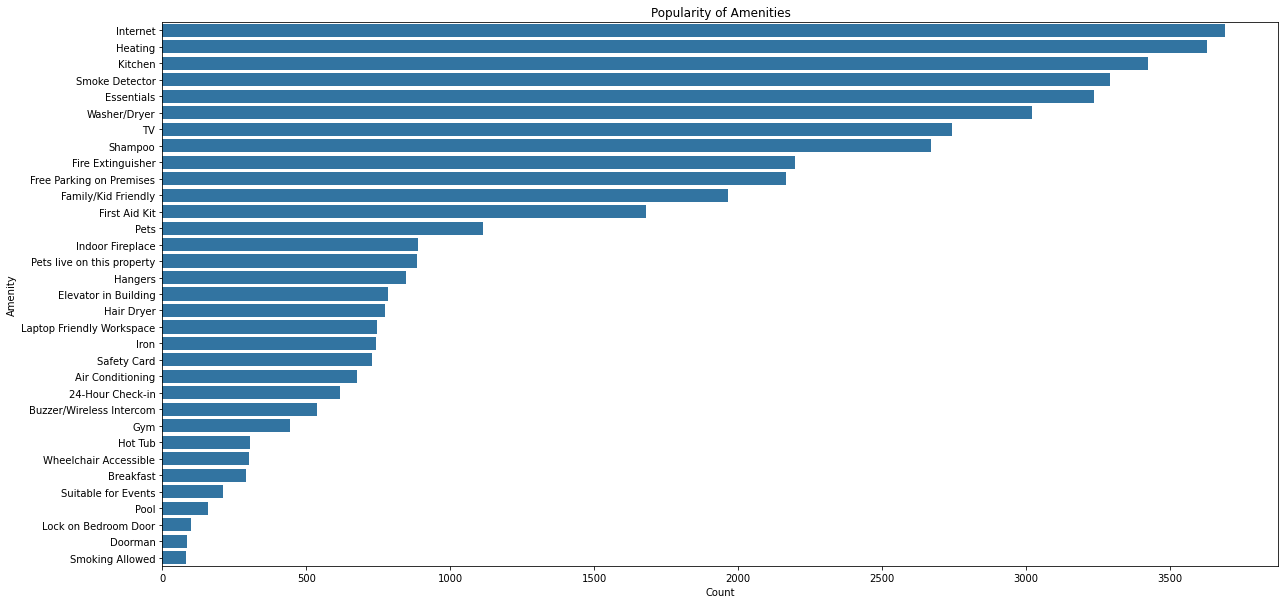

In [12]:
plt.figure(figsize=(20, 10))
base_color = sns.color_palette()[0]
sns.barplot(y=amenities_order.index, x=amenities_order.values, color=base_color);
plt.title('Popularity of Amenities')
plt.xlabel('Count')
plt.ylabel('Amenity');

In [13]:
{k: v for [k, v] in amenities_order.reset_index().values}

{'Internet': 3692,
 'Heating': 3627,
 'Kitchen': 3423,
 'Smoke Detector': 3291,
 'Essentials': 3237,
 'Washer/Dryer': 3022,
 'TV': 2741,
 'Shampoo': 2670,
 'Fire Extinguisher': 2196,
 'Free Parking on Premises': 2167,
 'Family/Kid Friendly': 1963,
 'First Aid Kit': 1680,
 'Pets': 1114,
 'Indoor Fireplace': 886,
 'Pets live on this property': 883,
 'Hangers': 846,
 'Elevator in Building': 785,
 'Hair Dryer': 774,
 'Laptop Friendly Workspace': 745,
 'Iron': 742,
 'Safety Card': 727,
 'Air Conditioning': 677,
 '24-Hour Check-in': 616,
 'Buzzer/Wireless Intercom': 538,
 'Gym': 442,
 'Hot Tub': 303,
 'Wheelchair Accessible': 300,
 'Breakfast': 291,
 'Suitable for Events': 209,
 'Pool': 159,
 'Lock on Bedroom Door': 100,
 'Doorman': 85,
 'Smoking Allowed': 82}

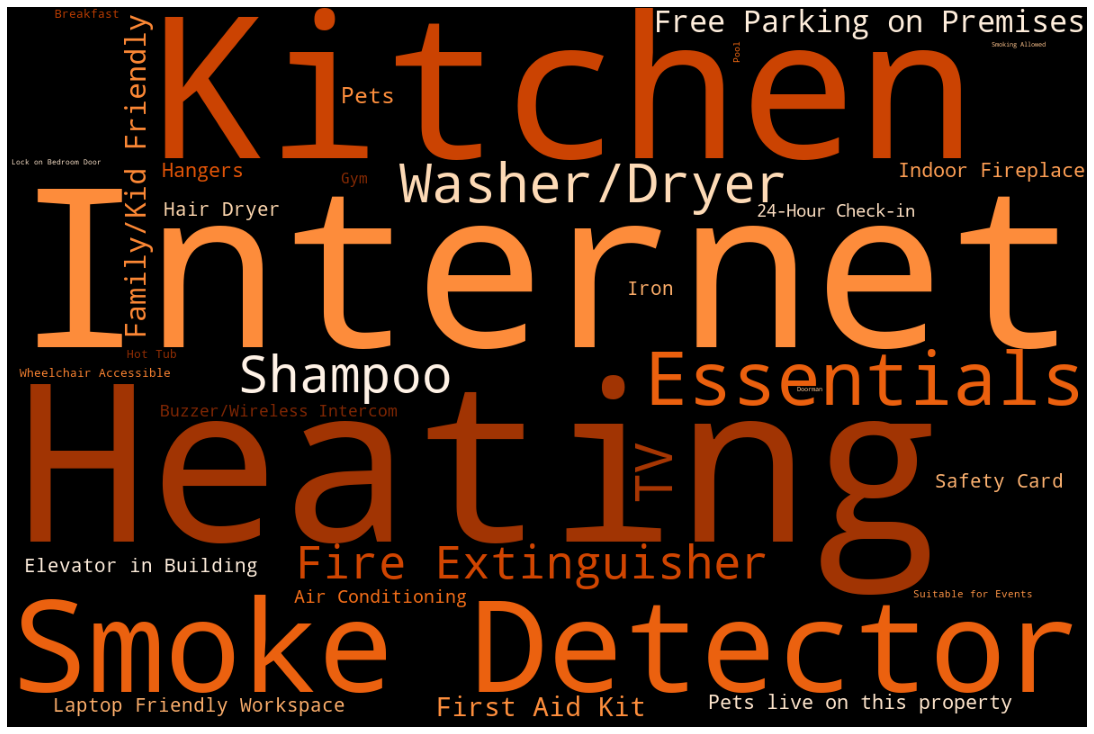

In [14]:
wc = WordCloud(height=800, width=1200, colormap='Oranges')
wc.generate_from_frequencies({k: v for [k, v] in amenities_order.reset_index().values})
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Question 2: How are amenities and prices distributed?

In [15]:
amenities_and_price = pd.concat([amenities_cleaned, df[['price']]], axis=1)
amenities_and_price.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Doorman,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,...,Shampoo,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Internet,Smoke Detector,TV,Pets,Washer/Dryer,price
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,1,85.0
1,0,0,0,1,0,0,1,1,1,1,...,0,0,0,0,1,1,1,0,1,150.0
2,0,1,0,0,0,0,1,1,0,0,...,1,0,0,0,1,1,1,1,1,975.0
3,0,0,0,0,0,0,1,1,1,0,...,1,0,0,0,1,1,0,0,1,100.0
4,0,0,0,0,0,0,1,1,1,1,...,1,0,0,0,1,1,1,0,0,450.0


In [16]:
price_amenity_availability = amenities_and_price.melt(id_vars=['price'], var_name='amenity', value_name='available')
price_amenity_availability.head()
mean_price_amenity_availability = price_amenity_availability.groupby(['amenity', 'available']).mean()['price'].reset_index()
mean_price_amenity_availability.rename(columns={'price': 'mean_price'})
mean_price_amenity_availability.head()

,amenity,available,price
0,24-Hour Check-in,0,127.285134
1,24-Hour Check-in,1,131.568182
2,Air Conditioning,0,122.518625
3,Air Conditioning,1,153.296898
4,Breakfast,0,130.645024


In [17]:
price_amenity_availability.shape

(125994, 3)

<AxesSubplot:xlabel='price', ylabel='amenity'>

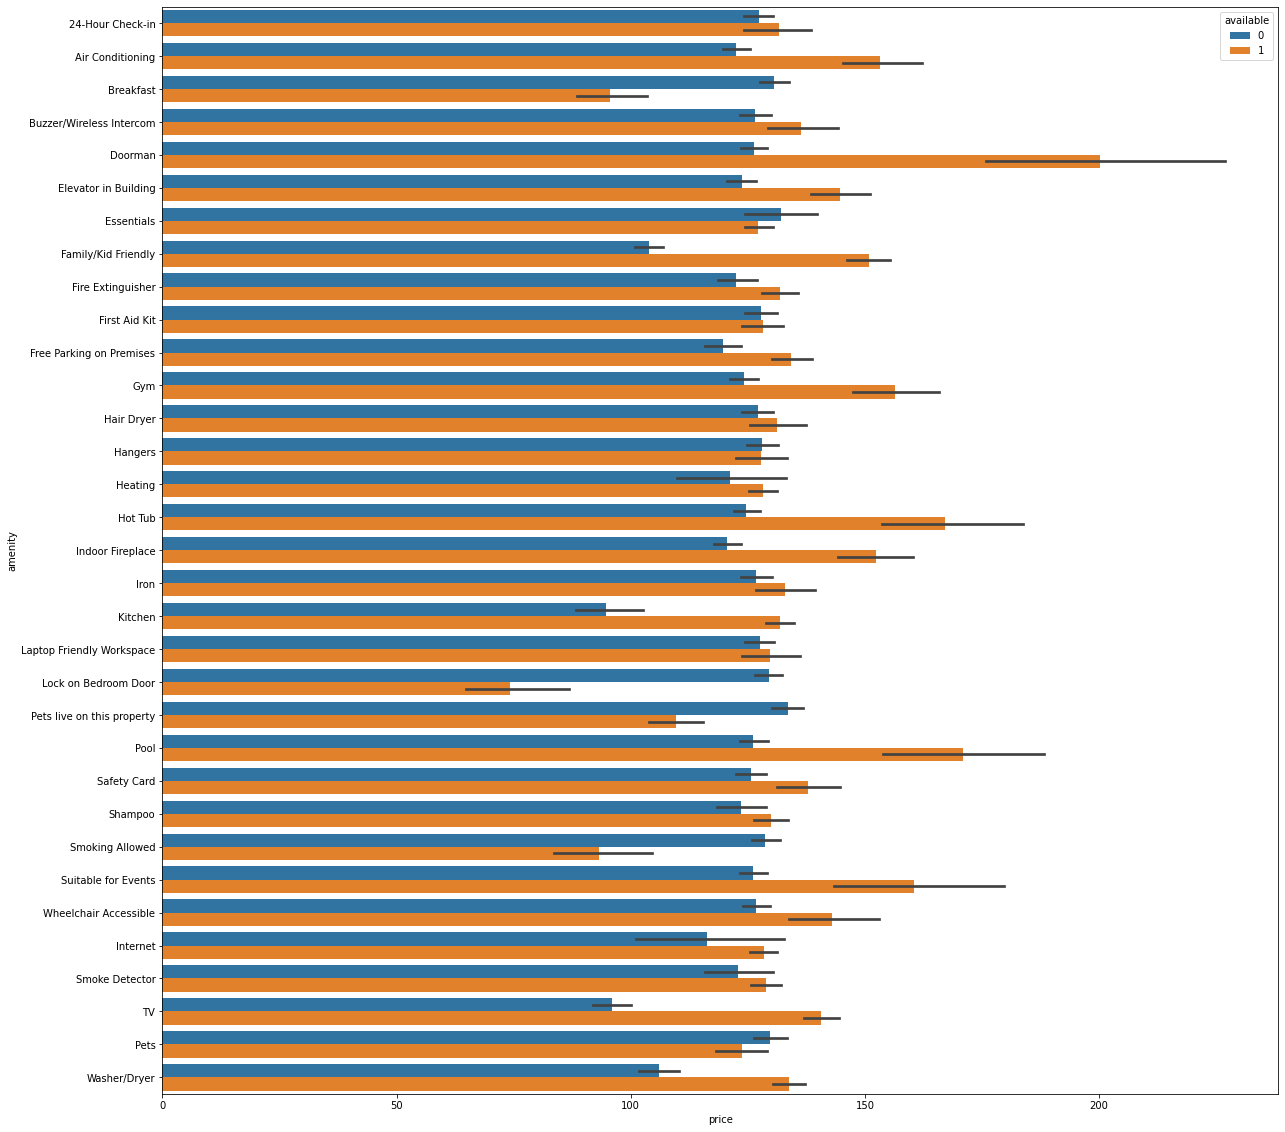

In [18]:
plt.figure(figsize=(20, 20))
sns.barplot(data=price_amenity_availability, y='amenity', x='price', hue='available')

In [19]:
X, y = amenities_cleaned, df['price']
linear_model = LinearRegression()
linear_model.fit(X, y)
amenities_coefs = pd.DataFrame({
    'amenity': X.columns,
    'coef': linear_model.coef_
})
amenities_coefs.sort_values('coef', inplace=True)

In [20]:
linear_model.intercept_

103.53944633279181

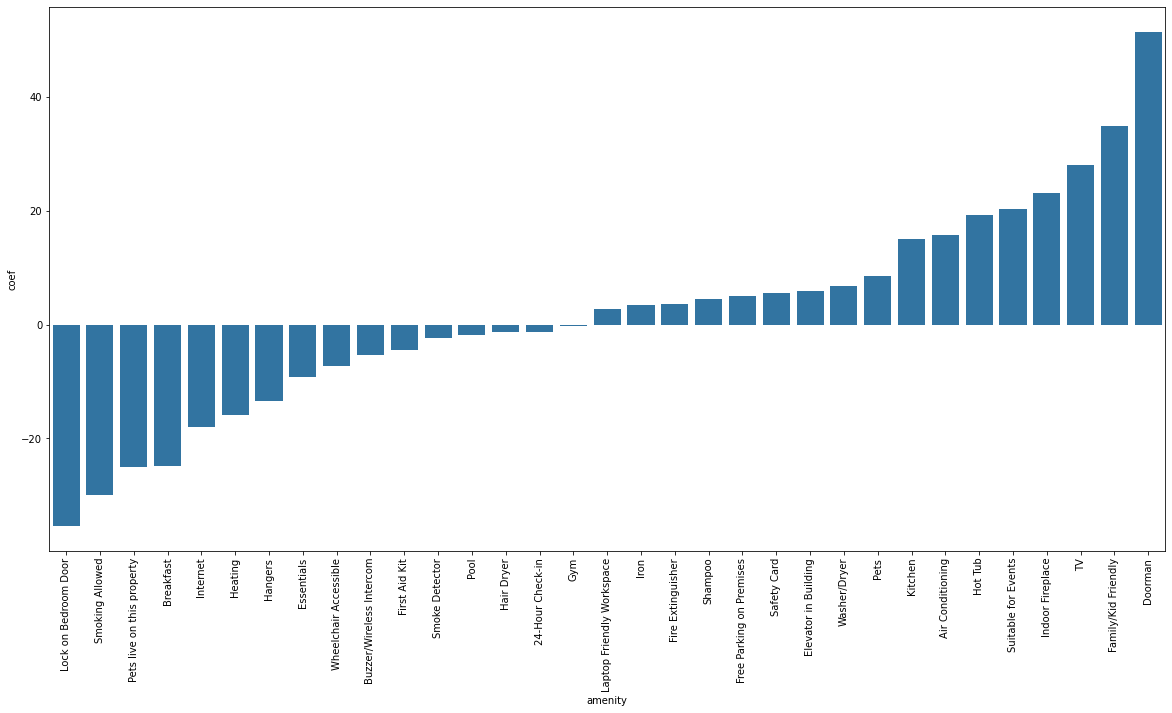

In [21]:
plt.figure(figsize=(20, 10))
sns.barplot(data=amenities_coefs, x='amenity', y='coef', color=sns.color_palette()[0])
plt.xticks(rotation=90);

# Question 3: How are amenities and reviews distributed? 

In [22]:
df['review_scores_rating'].isna().mean()

0.16946045049764275

In [23]:
amenities_and_review = pd.concat([amenities_cleaned, df[['review_scores_rating']]], axis=1)
amenities_and_review.dropna(inplace=True)

In [24]:
amenities_availability_rating = amenities_and_review.melt(id_vars=['review_scores_rating'])
amenities_availability_rating.columns = ['rating', 'amenity', 'availability']
amenities_availability_rating.head()

,rating,amenity,availability
0,95.0,24-Hour Check-in,0
1,96.0,24-Hour Check-in,0
2,97.0,24-Hour Check-in,0
3,92.0,24-Hour Check-in,0
4,95.0,24-Hour Check-in,0


<AxesSubplot:xlabel='rating', ylabel='amenity'>

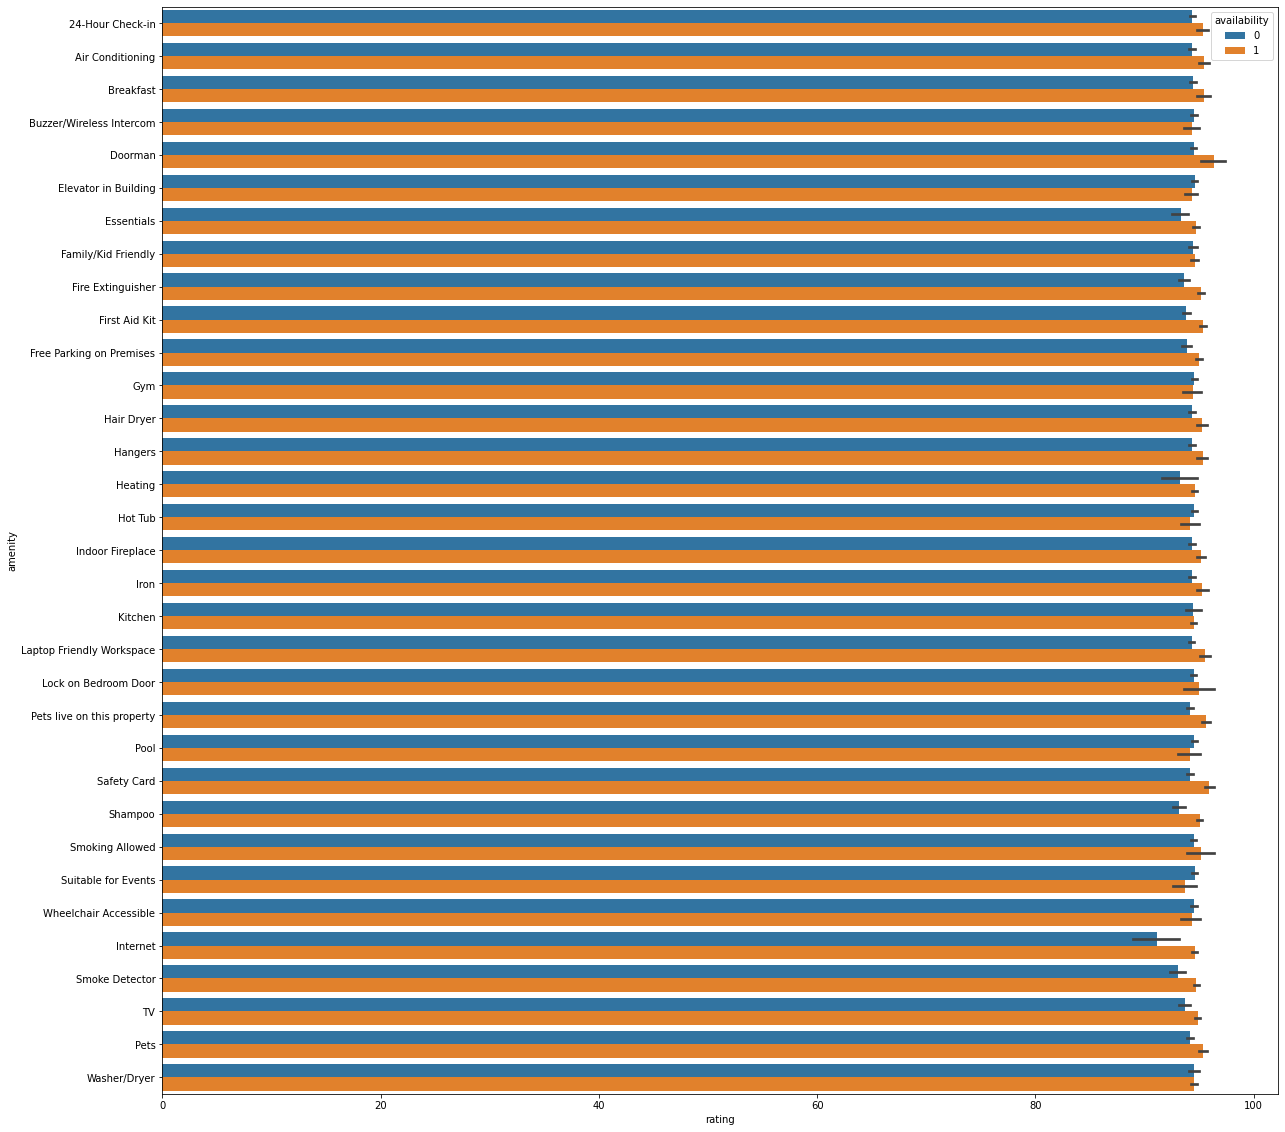

In [25]:
plt.figure(figsize=(20, 20))
sns.barplot(data=amenities_availability_rating, y='amenity', x='rating', hue='availability')

In [26]:
X, y = amenities_and_review.drop(columns=['review_scores_rating']), amenities_and_review['review_scores_rating']
linear_model_rating = LinearRegression()
linear_model_rating.fit(X, y)
amenities_rating_coefs = pd.DataFrame({
    'amenity': X.columns,
    'coef': linear_model_rating.coef_
})
amenities_rating_coefs.sort_values('coef', inplace=True)

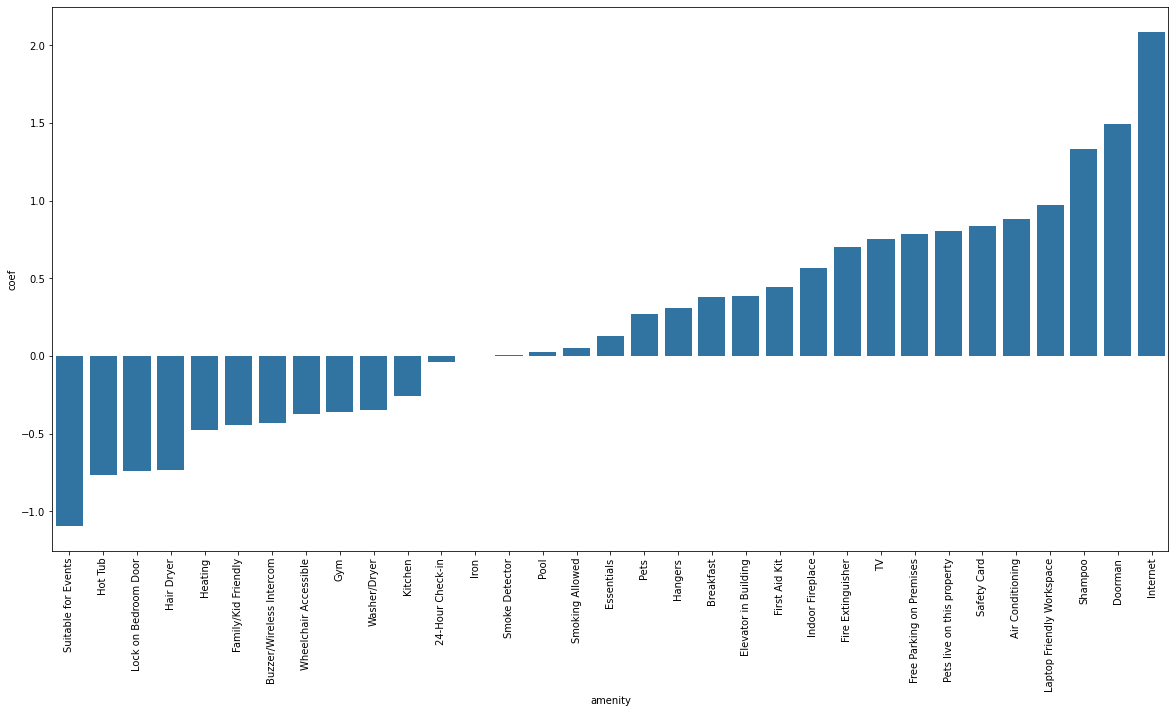

In [27]:
plt.figure(figsize=(20, 10))
sns.barplot(data=amenities_rating_coefs, y='coef', x='amenity', color=sns.color_palette()[0])
plt.xticks(rotation=90);

## Question 4: Is there correlation between amenities?

<AxesSubplot:>

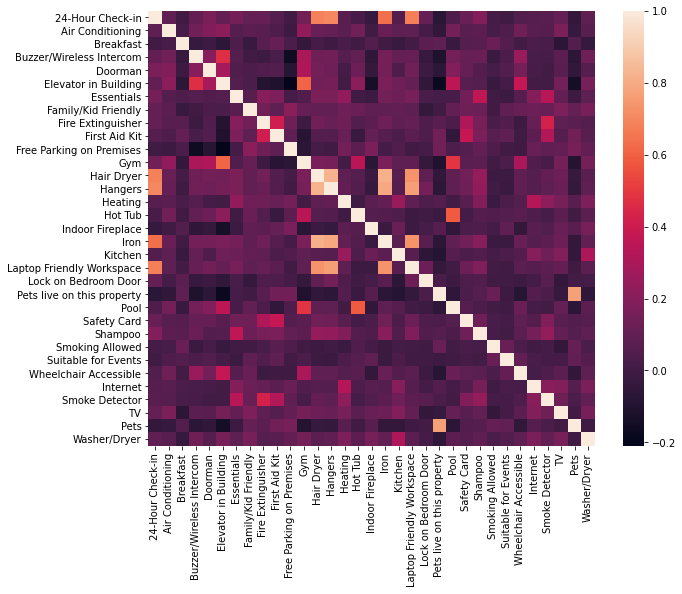

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(amenities_cleaned.corr())